# Recommendation systems: Deep Model

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)

In [696]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [697]:
import sys
sys.path.append('./src')

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from callback import MetricsPlotter
from util import tf_detected_devices, tf_version, plot_model, dataframe_to_dataset
from model import EmbeddingDenseModelFactory, Recommender, ValueIndexMapper, Model
from data import InMemoryXyDataGenerator, MovieLensDataSource, Dataset

### Check environment

Show GPU model:

In [698]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


Let's check tensorflow version:

In [699]:
tf_version()

'Tensorflow version: 2.3.0'

Let's check devices that tensorflow detect:

In [700]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:XLA_CPU:0,XLA_CPU,16G,device: XLA_CPU device
2,/device:XLA_GPU:0,XLA_GPU,16G,device: XLA_GPU device


[What is XLA?](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)

### Download dataset

Create a data source to download and read dataset files:

In [701]:
ds = MovieLensDataSource()

In [702]:
dataset = ds.dataset()

Available files:

In [703]:
print(ds.files())

['ratings.csv', 'links.csv', 'movies.csv', 'tags.csv']


Rating that users give to each movie:

In [704]:
dataset.ratings().head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


Movie catalog: Each movie has a tittle and a list of genres.

In [705]:
dataset.movies().head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [706]:
dataset.tags().head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [707]:
dataset.links().head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [708]:
dataset.highest_user_ratings(limit=15).head()

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346


Get 15 moviles with highest total ratings sum:

In [709]:
dataset.highest_movie_ratings(limit=15).head()

,rating
movieId,
356,329
318,317
296,307
593,279
2571,278


Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [710]:
dataset.top_user_vs_movies(limit=30)

movieId,1,47,50,110,150,260,296,318,356,457,...,1198,1210,2028,2571,2762,2858,2959,4993,5952,7153
userId,,,,,,,,,,,,,,,,,,,,,
19,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,2.0,4.0,...,5.0,3.0,NaN,4.0,4.0,4.0,5.0,NaN,NaN,NaN
68,2.5,4.0,3.0,2.5,3.0,5.0,2.0,3.0,3.5,4.5,...,5.0,5.0,4.0,4.5,2.5,5.0,2.5,4.5,4.0,4.5
105,NaN,5.0,5.0,3.5,NaN,4.0,5.0,5.0,3.5,NaN,...,4.0,NaN,5.0,4.0,4.5,5.0,5.0,4.0,4.0,4.5
111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,5.0,NaN,...,NaN,NaN,NaN,0.5,NaN,4.0,5.0,NaN,NaN,NaN
177,5.0,4.5,4.0,NaN,4.0,2.5,5.0,5.0,5.0,NaN,...,3.5,3.0,NaN,3.0,NaN,4.0,4.0,2.0,2.0,2.0
182,4.0,4.0,4.5,3.5,2.5,3.5,5.0,4.5,5.0,3.5,...,3.5,2.5,3.0,5.0,4.0,5.0,5.0,3.0,3.0,1.0
232,3.5,4.5,NaN,4.5,4.5,4.5,5.0,5.0,4.0,NaN,...,4.5,5.0,5.0,4.5,5.0,NaN,4.5,3.5,4.0,4.0
249,4.0,5.0,4.0,5.0,2.5,5.0,4.0,4.5,4.5,4.5,...,5.0,4.5,4.5,5.0,4.0,4.5,5.0,5.0,4.5,5.0
274,4.0,4.0,4.0,4.5,NaN,3.0,5.0,4.5,4.5,3.5,...,4.0,4.0,4.0,4.0,4.0,5.0,5.0,3.0,3.5,3.0


Users and movies count:

In [711]:
n_users, n_movies = dataset.n_users(), dataset.n_movies()
n_users, n_movies

(610, 9724)

Min and max rating:

In [712]:
min_rating, max_rating = dataset.min_rating(), dataset.max_rating()
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [713]:
X = dataset.ratings()[['user', 'movie']].values
y = dataset.ratings()['rating'].values

Show features an label for first sample:

In [714]:
X[0], y[0]

(array([0, 0]), 4.0)

Split data to train, validation and test sets:

In [715]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01) # , random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((99827, 2), (1009, 2), (99827,), (1009,))

### Deep Model: User and Movie embeddings + Dense layers 

In [716]:
batch_size=128

def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    batch_size, 
    shuffle=True, 
    to_input=to_input
)

validation_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    batch_size, 
    to_input=to_input
)

In [717]:
def evaluate_xy_model(model, X, y, batch_size):
    data_generator = InMemoryXyDataGenerator(X, y, len(y), to_input=to_input)
    X_t, y_t = data_generator[0]
    print(X_t[0].shape)
    return model.evaluate(X_t, y_t, batch_size=batch_size, verbose=0)

In [718]:
model = EmbeddingDenseModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=100,
    min_rating=min_rating, 
    max_rating=max_rating
)

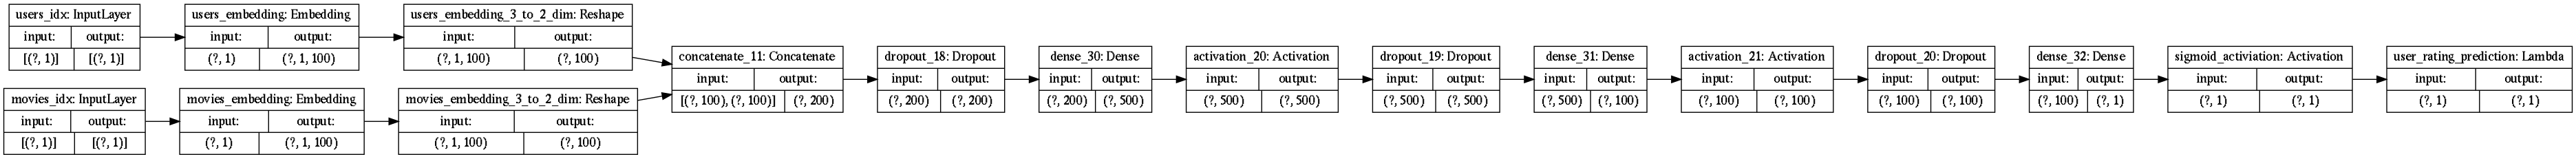

In [719]:
plot_model(model)

In [720]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 100)       61000       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 100)       972400      movies_idx[0][0]                 
____________________________________________________

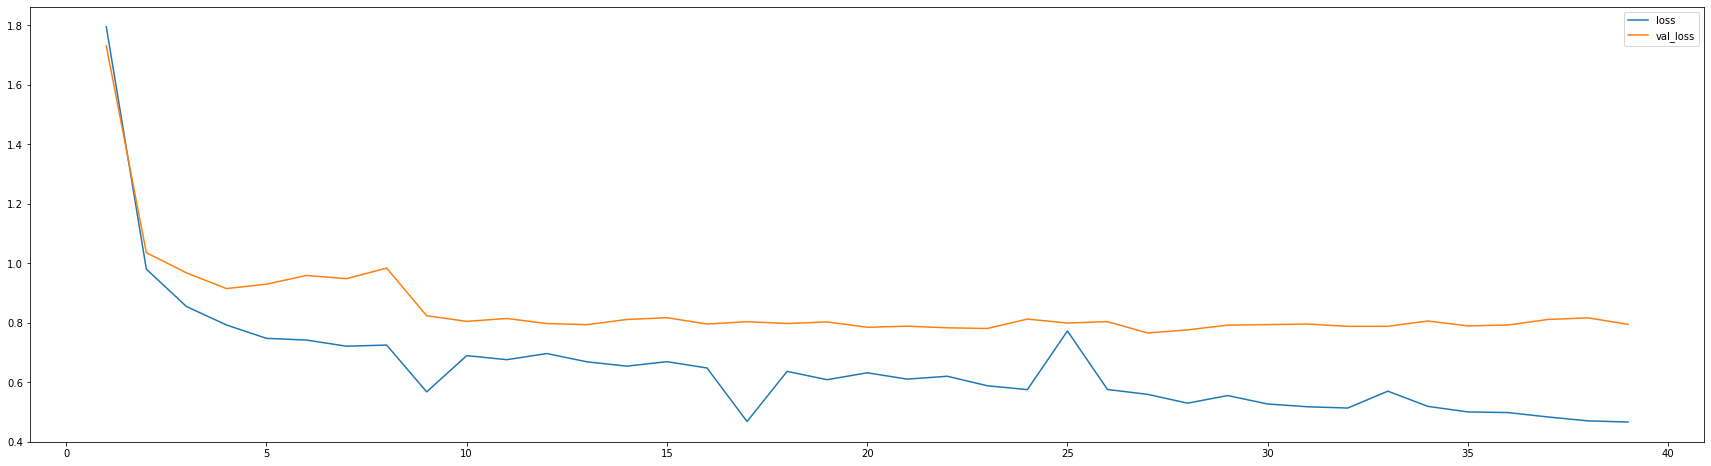

731/779 [===========================>..] - ETA: 0s - loss: 0.4616

Evaluate model (Each 105 steps):
7/7 [==============================] - 0s 2ms/step - loss: 0.8076

Validation:
  - Loss (40): 0.807580 (⟰ 0.01280445)

Continue model train:
779/779 [==============================] - 8s 11ms/step - loss: 0.4973 - val_loss: 0.8033


In [721]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1, 
    callbacks=[
        MetricsPlotter(
            validation_generator=validation_generator, 
            metrics_names=['loss'],
            plot_interval=100,
            evaluate_interval=105,
            batch_size=batch_size
        )
    ]
)

In [722]:
evaluate_xy_model(model, X_val, y_val, batch_size)

(1009,)


0.7985808253288269

In [723]:
model3.save_weights('./deep_model_weights.h5')

### Check rating prediction

Predict a non-existent rating:

In [724]:
Model(model).predict_rating(user_idx=104, movie_idx=0)

,movie,predicted_rating
0,0,3.604048


In [725]:
 dataset.rating_of(user_idx=104, movie_idx=0)

,user,movie,userId,movieId,rating,title,genres


Predict ratings used to train model:

In [726]:
def compare_rating(user_idx, movie_idx):
    movie_ratting = dataset.rating_of(user_idx=user_idx, movie_idx=movie_idx)
    predicted_movie_ratting = Model(model).predict_rating(user_idx, movie_idx)
    result = pd.merge(movie_ratting, predicted_movie_ratting, how='left', on='movie')
    return result[['user', 'movie', 'title', 'predicted_rating', 'rating']]

In [727]:
import random

train_input = pd.DataFrame(X, columns=['user', 'movie'])

def rand_compare_train_rating():
    user_idx = random.choice(train_input['user'])
    movie_idx = random.choice(train_input['movie'])
    return compare_rating(user_idx, movie_idx)

In [728]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,559,4640,Master and Commander: The Far Side of the Worl...,3.796034,3.0


In [729]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,112,1420,From Here to Eternity (1953),3.915911,4.0


In [730]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,63,2824,Scary Movie (2000),3.076777,2.5


In [731]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,390,3143,Amores Perros (Love's a Bitch) (2000),3.986828,2.0


In [732]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,63,4604,Mystic River (2003),3.970555,3.5


In [733]:
rand_compare_rating()

,user,movie,title,predicted_rating,rating
0,17,549,Dragonheart (1996),2.924995,3.0


### Check recommendations

In [734]:
recommender = Recommender(model, dataset)

#### Top movies for a user

In [735]:
def rand_compare_top_movies():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    display(recommender.top_movies_by_user_id(user_id, limit=10))

In [736]:
rand_compare_top_movies()

User Id: 510



,predicted_rating,title,movieId,movie
232,4.371521,"Shawshank Redemption, The (1994)",318,277
1395,4.363909,"Three Billboards Outside Ebbing, Missouri (2017)",177593,9600
382,4.293272,Seven Samurai (Shichinin no samurai) (1954),2019,1493
72,4.279982,Apocalypse Now (1979),1208,908
2158,4.255462,Guess Who's Coming to Dinner (1967),3451,2579
7399,4.228880,Bad Boy Bubby (1993),26810,5567
3547,4.218500,"Celebration, The (Festen) (1998)",2360,1761
2783,4.205043,Pierrot le fou (1965),7748,4997
1136,4.187503,"Godfather: Part II, The (1974)",1221,921
3039,4.175468,True Grit (1969),3494,2606


#### Similar movies

In [754]:
def rand_similar_movies():
    movie_id = random.choice(dataset.movie_ids())
    print(f'Movie\n')
    display(dataset.movie_by_id(movie_id))
    print(f'Similars (Unordered)')
    display(recommender.movies_similar_to(movie_id, limit=5))

In [755]:
rand_similar_movies()

Movie



,movieId,title,genres
3573,4893,When a Stranger Calls (1979),Horror|Thriller


Similars (Unordered)


,movieId,title,genres
1499,2024,"Rapture, The (1991)",Drama|Mystery
2412,3203,Dead Calm (1989),Thriller
3573,4893,When a Stranger Calls (1979),Horror|Thriller
5278,8711,Mr. Blandings Builds His Dream House (1948),Comedy
5506,26422,Hair (1979),Comedy|Drama|Musical


#### Similar users

In [752]:
def rand_similar_users():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    print(f'Similars (Unordered): {recommender.users_similar_to(user_id, limit=10)}')

In [753]:
rand_similar_users()

User Id: 486

Similars (Unordered): [486, 544, 452, 53, 523, 584, 337, 319, 475, 43]
